In [233]:
from math import log10
from collections import Counter, defaultdict
import codecs
import math


# 中文 Language Model

In [234]:
filename = "corpus.txt"
V1 = 10000
V2 = 10000**2
k = 10

def to_ngrams(unigrams, length):
    return zip(*[unigrams[i:] for i in range(length)])

unigram_counts, bigram_counts = Counter(), Counter()
with open(filename, 'r') as text_file:
    for line in text_file:
        unigram_counts.update(line)
        bigram_counts.update(to_ngrams(line, 2))

In [235]:
print(unigram_counts.most_common(5))

[('，', 410592), ('的', 257505), ('。', 161286), ('一', 92968), ('是', 88867)]


In [236]:
print(bigram_counts.most_common(5))

[(('我', '們'), 15613), (('，', '我'), 13995), (('一', '個'), 13063), (('，', '但'), 9518), (('，', '而'), 8847)]


In [237]:
# compute N1, N2, N3...
unigram_Nr = Counter(unigram_counts.values())
bigram_Nr = Counter(bigram_counts.values())
# compute N0
unigram_Nr[0] = V1 - len(unigram_counts)
bigram_Nr[0] = V2 - len(bigram_counts)
print(unigram_Nr[0], bigram_Nr[0])

3991 99313298


In [238]:
# compute r
unigram_r = [(i+1) * unigram_Nr[i+1] / unigram_Nr[i] for i in range(k)]
bigram_r = [(i+1) * bigram_Nr[i+1] / bigram_Nr[i] for i in range(k)]
print(unigram_r)
print(bigram_r)

[0.10398396391881734, 1.3156626506024096, 2.340659340659341, 3.1737089201877935, 3.4023668639053253, 5.947826086956522, 6.078947368421052, 6.545454545454546, 8.444444444444445, 10.921052631578947]
[0.0031815880286243238, 0.6897909321653047, 1.525573969057975, 2.5323901981305714, 3.4326635314236853, 4.47054427699589, 5.380955034267566, 6.408814149028704, 7.361563517915309, 8.57853982300885]


In [239]:
# compute normalize factor
# compute N
unigram_N = sum(unigram_counts.values())
bigram_N = sum(bigram_counts.values())
print(unigram_N, bigram_N)

7672143 7663643


In [240]:
# compute new probability sum
unigram_N_ = unigram_N + k * unigram_Nr[k]
bigram_N_ = bigram_N + k * bigram_Nr[k]
print(unigram_N_, bigram_N_)

7672973 7741193


In [241]:
# normalize factor: N/N’
unigram_norm_factor = unigram_N / unigram_N_
bigram_norm_factor = bigram_N / bigram_N_
print(unigram_norm_factor, bigram_norm_factor)

0.9998918281088699 0.9899821642478104


In [242]:
# Estimating P(w) and P(w’|w)
def prob_1word(unigram):
    count = unigram_counts[unigram]
    r = unigram_r[count] if count < k else count
    return log10(r / unigram_N_)
def prob_2words(text_front, text_rear):
    count = bigram_counts[text_front, text_rear]
    r = bigram_r[count] if count < k else count
    return log10(r / bigram_N_)
def prob_word_by_word(text_front, text_rear):
    return prob_2words(text_front, text_rear) - prob_1word(text_front)
def prob_words(words):
    return prob_1word(words[0]) + sum(prob_word_by_word(words[i-1], words[i]) for i in range(1, len(words)))
def prob_text(text):
    return prob_words(text.lower().split())

In [243]:
# your code here (probability of word sequences)

# (you can use log to speed up the calculation)
unicount_log = {k: log10(v) for k, v in unigram_counts.items()}
bicount_log = {k: log10(v) for k, v in bigram_counts.items()}
unigram_r_log = [log10(r) for r in unigram_r]
bigram_r_log = [log10(r) for r in bigram_r]
unigram_N_log = log10(unigram_N_)
bigram_N_log = log10(bigram_N_)


def prob_1word(unigram):
    count = unigram_counts[unigram]
    r = unigram_r_log[count] if count < k else unicount_log[unigram]
    return r - unigram_N_log
def prob_2words(text_front, text_rear):
    count = bigram_counts[text_front, text_rear]
    r = bigram_r_log[count] if count < k else bicount_log[text_front, text_rear]
    return r - bigram_N_log

### 階段測試

In [244]:
print(prob_1word(u'清'))
print(prob_1word(u'華'))
print(prob_2words(u'清', u'華'))
print(prob_word_by_word(u'清',u'華'))

-3.2520005018213456
-3.2424991497464855
-4.366363661723275
-1.1143631599019295


In [245]:
import pandas
%matplotlib inline
s = pandas.Series(prob_1word(unigram) for unigram in unigram_counts)

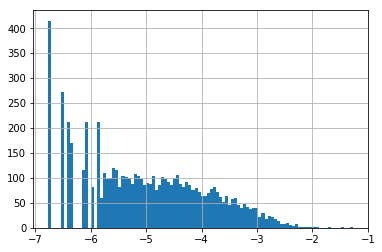

In [246]:
s.hist(bins=100)

# 注音對應表

In [247]:
bpmf1_to_chars = defaultdict(list)
bpmf_frequency_in_chinese = defaultdict()
with codecs.open("bpmf.txt", 'r', 'utf-8') as bpmf_file:
    for line in bpmf_file:
        data_list = line.split('	')
        
        bpmf = data_list[0]
        chinese_word = data_list[2]
        if len(bpmf1_to_chars[bpmf]) == 0:
            bpmf1_to_chars[bpmf] = [chinese_word]
        else:
            bpmf1_to_chars[bpmf].append(chinese_word)
        
        chinese_frequency = int(data_list[1])
        if chinese_word not in bpmf_frequency_in_chinese:
            bpmf_frequency_in_chinese[chinese_word] = {bpmf: chinese_frequency}
        else:
            if bpmf in bpmf_frequency_in_chinese[chinese_word]:
                bpmf_frequency_in_chinese[chinese_word].update({bpmf: chinese_frequency+bpmf_frequency_in_chinese[chinese_word][bpmf]})
            else:
                bpmf_frequency_in_chinese[chinese_word].update({bpmf: chinese_frequency})


### 階段測試

In [248]:
bpmf1_to_chars['ㄨ'][:10]

['唯', '玩', '臥', '悟', '悟', '無', '瘟', '霧', '娃', '襪']

[u'溫',
 u'無',
 u'衛',
 u'罔',
 u'晚',
 u'頑',
 u'挖',
 u'蔚',
 u'烷',
 u'王']

In [249]:
bpmf_frequency_in_chinese['阿']

{'ㄚ': 771, 'ㄜ': 32}

# viterbi

In [250]:
def start_p(word):
    return prob_1word(word)

def trans_p(word1, word2):
    return prob_word_by_word(word1, word2)

def emit_p(word, bpmf):
    # Handle some word not in dict such as ，
    if word not in bpmf_frequency_in_chinese:
        return 0
    bpmf_frequency_dict = bpmf_frequency_in_chinese[word]
    
    # Handle if user input chinese.
    if bpmf not in bpmf_frequency_dict:
        return 0
    
    sum_of_frequency = sum(bpmf_frequency_dict.values())
    return math.log10(bpmf_frequency_dict[bpmf] / sum_of_frequency)


In [252]:
def viterbi(obs, states):
    V = [{}]
    path = {}

    # Initialize base cases (t == 0)
    for y in states[0]:
        V[0][y] = start_p(y) + emit_p(y, obs[0])  # emit_p[y][obs[0]
        path[y] = [y]

    # Run Viterbi for t > 0
    for t in range(1,len(obs)):
        V.append({})
        newpath = {}

        for y in states[t]:
            (prob, state) = max([(V[t-1][y0] + trans_p(y0, y) + emit_p(y, obs[t]), y0) for y0 in states[t-1]])
            V[t][y] = prob
            newpath[y] = path[state] + [y]

        # Don't need to remember the old paths
        path = newpath

### for log ###
#     result = []
#     for y in states[len(obs) - 1]:
#         result.append((V[len(obs) - 1][y], y))
#     (prob, state) = max(result)
#     print(result)
#     print(path)
### for log ###

    (prob, state) = max([(V[len(obs) - 1][y], y) for y in states[len(obs) - 1]])
    return (prob, path[state])


In [253]:
def bpmf1s_to_chars(sentence):
    observations = ()
    emission = {}
    for index, word in enumerate(sentence):
        observations += tuple(word)
        chinese_list = bpmf1_to_chars[word]
        if len(chinese_list) is 0:
            chinese_list = [word]
        emission[index] = chinese_list

    prob, path = viterbi(observations, emission)
    return (prob, path)

### 最終測試

In [255]:
bpmf1s_to_chars('ㄅㄕ')

(-3.1548887442172044, ['不', '是'])

(-3.1548887442172044,
 [u'不', u'是'],
 <matplotlib.axes.AxesSubplot object at 0x113c11a10>)

In [256]:
bpmf1s_to_chars(u'ㄓㄏㄇㄍㄓㄈ')

(-8.53669708842652, ['中', '華', '民', '國', '政', '府'])

(-8.53669708842652,
 [u'中', u'華', u'民', u'國', u'政', u'府'],
 <matplotlib.axes.AxesSubplot object at 0x113a22d90>)

In [257]:
bpmf1s_to_chars(u'ㄗㄖㄩㄧㄔㄌ')

(-10.605441609165581, ['自', '然', '語', '言', '處', '理'])

In [258]:
bpmf1s_to_chars(u'ㄑㄏㄉㄒ')

(-6.9140173283696615, ['清', '華', '大', '學'])

In [259]:
bpmf1s_to_chars(u'ㄗㄒㄍㄔ')

(-6.5238865919240565, ['資', '訊', '工', '程'])

In [260]:
bpmf1s_to_chars(u'ㄓㄕㄧㄅ書')

(-8.975520402582454, ['這', '是', '一', '本', '書'])

In [261]:
bpmf1s_to_chars(u'ㄌㄈㄨㄩㄉㄗㄔ架')

(-14.798908068226584, ['立', '法', '委', '員', '都', '在', '吵', '架'])

In [262]:
bpmf1s_to_chars(u'ㄨㄒ睡ㄐ')

(-7.211231492855711, ['我', '想', '睡', '覺'])

In [263]:
bpmf1s_to_chars(u'肚ㄗㄏㄜ，ㄎ點下ㄎ')

(-22.12693862822828, ['肚', '子', '很', '餓', '，', '快', '點', '下', '課'])